# Task 2&3

Frederik Rogge, Mouhammad Abu Rasheed and Homa Priya Tarigopula

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os
%matplotlib inline

from utils import *
from resampling import *
np.random.seed(0)


In [2]:
# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)


# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))


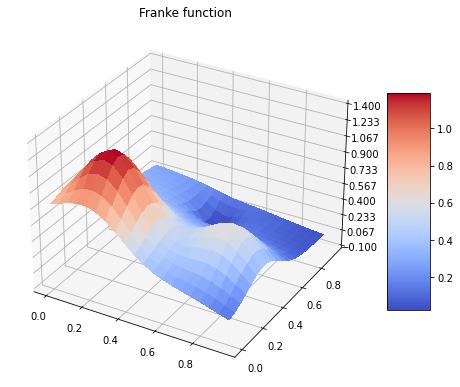

In [3]:
def plot_function(x, y, z, title=None):
    # Plot function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title is not None:
        plt.title(title)
    
    plt.show()
    
plot_function(x, y, z, 'Franke function')

### Part b) : Bias Variance trade-off on Franke function

#### Refer task 1 for MSE as a function of complexity 

In [4]:
n_bootstraps =100

k_values  = [5, 6, 7, 8, 9, 10]  # Number of folds

degree_values = np.arange(1, 6)  # Specify degree of polynomial to be fitted

# define the model we want to use 
solver = LinearRegression

#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True}

### Part b) : Bootstrap Resampling technique

In [5]:
def bootstrap(features, labels , k_values, degree_values, include_intercept = False , scaling= True , add_noise= True, mean = 0, std = 1, solver = LinearRegression, n_bootstraps = 1000,**solver_args):
  
    Maxpolydegree = np.max(degree_values)

    error_test = np.zeros((Maxpolydegree,  len(k_values)))
    bias_test = np.zeros((Maxpolydegree,  len(k_values)))
    variance_test = np.zeros((Maxpolydegree,  len(k_values)))

    error_train = np.zeros((Maxpolydegree,  len(k_values)))
    bias_train = np.zeros((Maxpolydegree,  len(k_values)))
    variance_train = np.zeros((Maxpolydegree,  len(k_values)))

    if add_noise :
        np.random.seed(1)
        labels_n = labels +  np.random.normal(mean, std, labels.shape )
    else :
        labels_n = labels
    
   
    for n,k in enumerate(k_values) :
        # Hold out some test data that is never used in training.
        X_train, X_test, y_train, y_test = train_test_split(features, labels_n, 
                                                            test_size=1/k, random_state = 2021)
    
        for nd, degree in enumerate(degree_values):
            # Input features transformation 
            poly = PolynomialFeatures(degree = degree, include_bias=not include_intercept)
            x_train = poly.fit_transform(X_train)
            x_test = poly.fit_transform(X_test)

            if scaling:
                # Scale data
                scaler = StandardScaler(with_std=True)
                x_train= scaler.fit_transform(x_train)
                x_test = scaler.transform(x_test)
            else:
                x_train = x_train
                x_test = x_test
                
            bs = Bootstrap()
                    
            error_test[nd,n], bias_test[nd,n], variance_test[nd,n], error_train[nd,n], bias_train[nd,n], variance_train[nd,n] = bs.resample(x_train, x_test, y_train, y_test, solver, n_bootstraps= n_bootstraps,**solver_args)

    return error_test, bias_test, variance_test,error_train , bias_train , variance_train 


In [6]:
def gen_plot(k_values, polynomial, estimated_mse, title , y_label, legend_label, fig_name):
    fig, ax = plt.subplots()
    for n,k in enumerate(k_values):
        plt.plot(polynomial, estimated_mse[:, n], label= legend_label +', k = '+ str(k)  )
        plt.xlabel('Polynomial degree')
        plt.ylabel( y_label)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        save_fig(fig , name =fig_name + legend_label )
    plt.title(title)
    plt.show()
    
    

#### Bootstrap bias variance tradeoff


P:\PhDOslo\CompSci\compsci-project\Notebooks\resampling.py:54: RuntimeWarning: overflow encountered in square
  error =  np.mean( np.mean((y - y_hat)**2, axis=1, keepdims=True) )
P:\PhDOslo\CompSci\compsci-project\Notebooks\resampling.py:55: RuntimeWarning: overflow encountered in square
  bias = np.mean( (y - np.mean(y_hat, axis=1, keepdims=True))**2 )
C:\Users\priya\anaconda3\envs\pyt\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


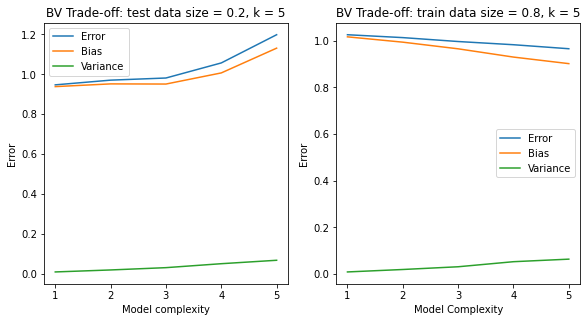

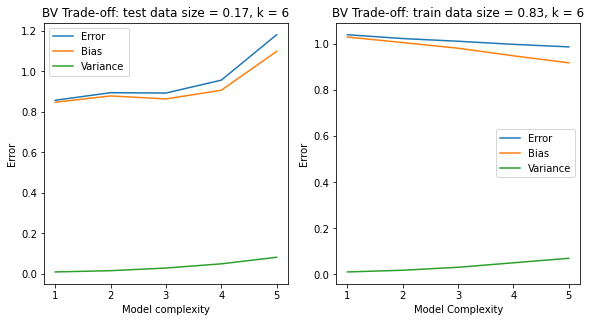

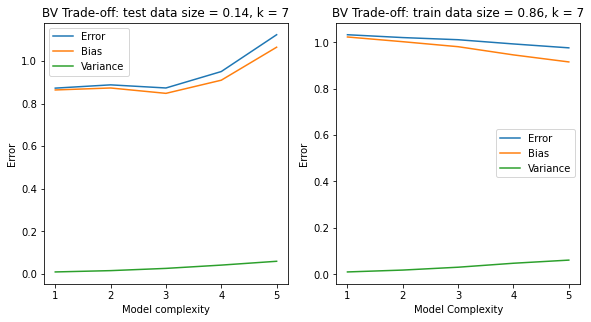

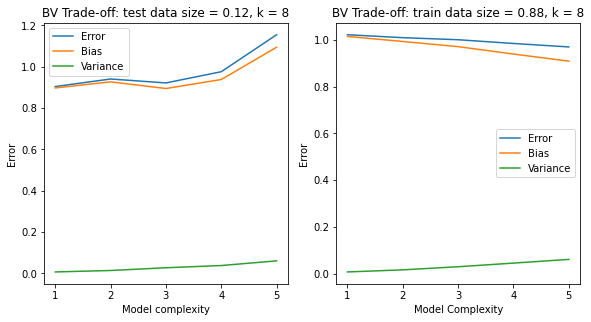

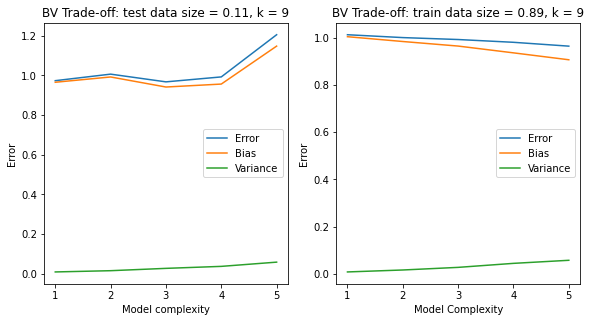

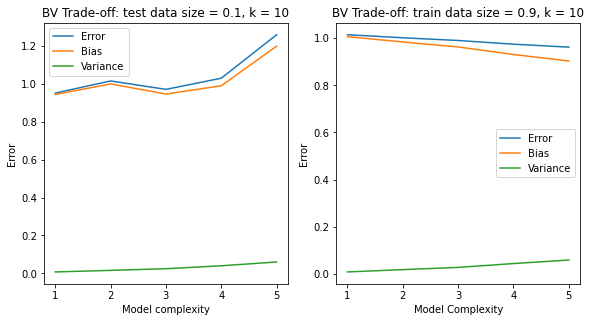

In [7]:
error_test, bias_test, variance_test,error_train , bias_train , variance_train = bootstrap(features, labels , k_values, degree_values, 
                              include_intercept= False , scaling= True , add_noise= True, mean = 0, std = 1,
                             solver= solver,  n_bootstraps= n_bootstraps, **solver_args)

Maxpolydegree = np.max(degree_values)
polynomial = np.zeros(Maxpolydegree)

for polydegree in range(1, Maxpolydegree+1):
    polynomial[polydegree-1] = polydegree

    
# plot bias-variance tradeoff
for n,k in enumerate(k_values): 
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(4.8*2, 4.8))
    ax0.plot(polynomial, error_test[:, n], label= 'Error')
    ax0.plot(polynomial, bias_test[:, n], label= 'Bias')
    ax0.plot(polynomial, variance_test[:, n], label= 'Variance')
    ax0.set_xlabel('Model complexity')
    ax0.set_ylabel('Error')
    ax0.legend()
    ax0.set_title('BV Trade-off: test data size = '+str(np.round(1/k, 2))+', k = '+ str(k))

    ax1.plot(polynomial, error_train[:, n], label= 'Error')
    ax1.plot(polynomial, bias_train[:, n], label= 'Bias')
    ax1.plot(polynomial, variance_train[:, n], label= 'Variance')
    ax1.set_xlabel('Model Complexity')
    ax1.set_ylabel('Error')
    ax1.legend()
    ax1.set_title('BV Trade-off: train data size = '+str(np.round(1-1/k, 2))+', k = '+ str(k))
    save_fig(f, name ='b_bv_tradeoff_'+str(k))


#### Bootstrap Error with respect to complexity and datasize for train and test data

In [8]:
def plot_bootstrap(features, labels , k_values, degree_values, fig_name, include_intercept= True,
                              scaling= True , add_noise= True, mean = 0, std = 1, solver= LinearRegression,  n_bootstraps= 1000, **solver_args):
    Maxpolydegree = np.max(degree_values)
    polynomial = np.zeros(Maxpolydegree)

    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = polydegree

    error_test, bias_test, variance_test,error_train , bias_train , variance_train = bootstrap(features, labels , k_values, degree_values, 
                              include_intercept, scaling, add_noise, mean , std, solver= solver,  n_bootstraps= 10, **solver_args)
    # generating plots
    gen_plot(k_values, polynomial, error_train,
                 title = 'Bootstrap error for Train data', 
                 y_label = 'Error',
                 legend_label = 'Train data',fig_name = fig_name )


    gen_plot(k_values, polynomial, error_test,
                 title = 'Bootstrap error for Test data', 
                 y_label = 'Error',
                 legend_label = 'Test data', fig_name= fig_name )

    
  
  
    

P:\PhDOslo\CompSci\compsci-project\Notebooks\resampling.py:54: RuntimeWarning: overflow encountered in square
  error =  np.mean( np.mean((y - y_hat)**2, axis=1, keepdims=True) )
P:\PhDOslo\CompSci\compsci-project\Notebooks\resampling.py:55: RuntimeWarning: overflow encountered in square
  bias = np.mean( (y - np.mean(y_hat, axis=1, keepdims=True))**2 )
C:\Users\priya\anaconda3\envs\pyt\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\priya\anaconda3\envs\pyt\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
P:\PhDOslo\CompSci\compsci-project\Notebooks\resampling.py:54: RuntimeWarning: overflow encountered in square
  error =  np.mean( np.mean((y - y_hat)**2, axis=1, keepdims=True) )
P:\PhDOslo\CompSci\compsci-project\Notebooks\resampling.py:55: RuntimeWarning: overflow encountered in square
  bias = np.mean( (y 

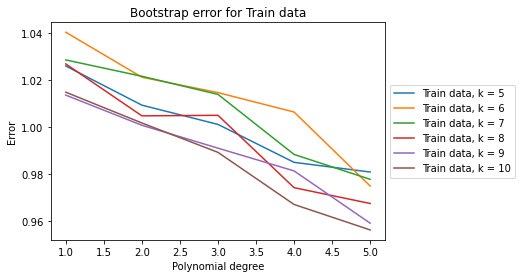

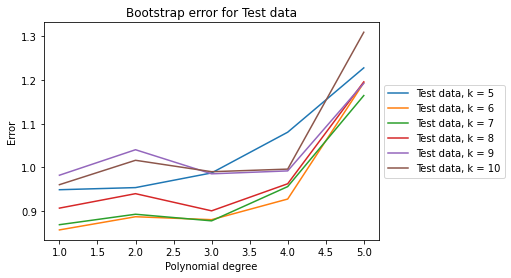

In [9]:
plot_bootstrap(features, labels ,k_values, degree_values, fig_name ='b_bootstrap_withnoise_', solver = solver, **solver_args )  

## Part c) : Cross validation as resampling techniques

### K-fold cross validation

In [10]:
def plot_kfold_implementation(features, labels , k_values, degree_values, fig_name, solver = LinearRegression,
                              include_intercept = True ,scaling= True , add_noise= True, mean = 0, std = 1, **solver_args):
    
    Maxpolydegree = np.max(degree_values)
    polynomial = np.zeros(Maxpolydegree)
    estimated_train_mse = np.zeros((Maxpolydegree,  len(k_values)))
    estimated_test_mse = np.zeros((Maxpolydegree,len(k_values)))

    if add_noise :
        np.random.seed(1)
        labels_n = labels +  np.random.normal(mean, std, labels.shape )
    else :
        labels_n = labels
    

    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = polydegree

    for degree in degree_values:
        for n,k in enumerate(k_values):
            
            kf = KFoldCV()      #Implementation from resampling.py
            
            test_MSE, train_MSE = kf.cv(features, labels_n , degree, k ,  include_intercept = True , scaling = scaling,  solver = solver, **solver_args )

            estimated_train_mse[degree-1, n] = np.mean(train_MSE)
            estimated_test_mse[degree-1, n] = np.mean(test_MSE)

    print('MSE on test-set : \n',estimated_test_mse)

    gen_plot(k_values, polynomial, estimated_train_mse,
             title = 'k-fold cv implementation for different order polynomials' ,
             y_label = 'MSE',
            legend_label = 'Train Error', fig_name = fig_name)

    gen_plot(k_values, polynomial, estimated_test_mse,
             title = 'k-fold cv implementation for different order polynomials' ,
             y_label = 'MSE',
            legend_label = 'Test Error', fig_name = fig_name)
    





#### With noise


MSE on test-set : 
 [[1.04759816 1.03621876 1.03795371 1.03080425 1.03235299 1.03504525]
 [1.08591581 1.04989276 1.08745607 1.0706907  1.0631547  1.06162568]
 [1.07683354 1.06764979 1.03957293 1.04108477 1.04012806 1.03315463]
 [1.54945564 1.24732393 1.31723977 1.3770104  1.28059704 1.09536324]
 [3.10272612 1.39434358 2.20685684 2.54751803 2.04617254 1.28492129]]


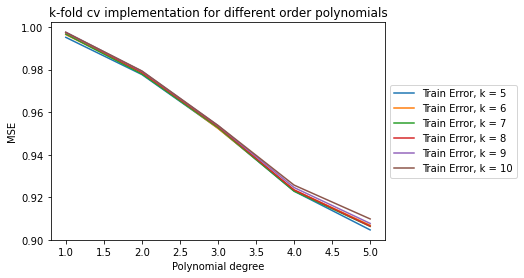

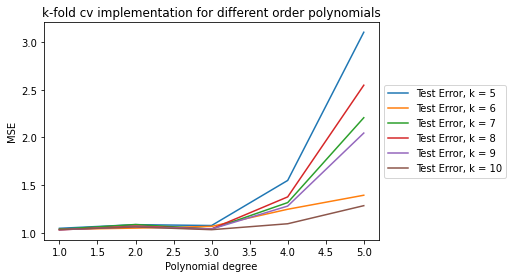

In [11]:

plot_kfold_implementation(features, labels ,k_values, degree_values, fig_name ='c_kfold_withnoise_', solver = solver, **solver_args) 

#### Without noise

MSE on test-set : 
 [[0.04576671 0.03874027 0.03839682 0.03467602 0.03352505 0.03379264]
 [0.11228997 0.0684227  0.05652764 0.04264218 0.03974759 0.03686937]
 [0.01820134 0.01337367 0.01286016 0.01229501 0.01220757 0.0111079 ]
 [0.09289967 0.04102599 0.02131225 0.01729308 0.01635007 0.01698624]
 [0.13528561 0.03653383 0.02653421 0.00997742 0.00951974 0.01010605]]


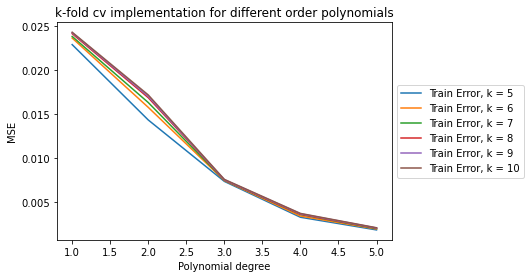

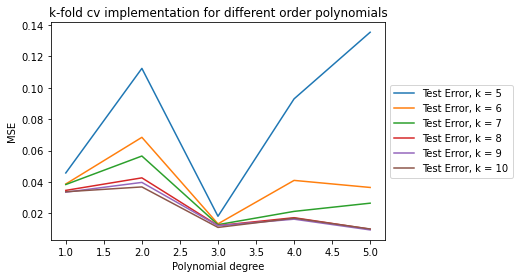

In [12]:

plot_kfold_implementation(features,labels , k_values, degree_values, scaling= True, add_noise= False, fig_name ='c_kfold_without_noise_',solver = solver, **solver_args ) 


### K-fold cross validation with scikit learn 

In [13]:
def plot_Kfold_scikit(features,labels , k_values, degree_values, fig_name ,scaling= True , add_noise= True, mean = 0, std = 1, solver = LR, **solver_args ):
    Maxpolydegree = np.max(degree_values)
    estimated_mse_sklearn = np.zeros((Maxpolydegree, len(k_values)))
    polynomial = np.zeros(Maxpolydegree)

    if add_noise :
        np.random.seed(1)
        labels_n = labels + np.random.normal(mean, std, labels.shape)
    else :
        labels_n = labels
    
    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = int(polydegree)

    for n,k in enumerate(k_values):
        for degree in degree_values:
            
            #Input feature transformation
            poly = PolynomialFeatures(degree, include_bias= not scaling)
            X_poly= poly.fit_transform(features)

            if scaling:
                # Scale data 
                scaler = StandardScaler(with_std=True)
                X_scaled = scaler.fit_transform(X_poly)
                        
            OLS = solver(**solver_args)
            
            # loop over folds in order to estimate the expectation value of the MSE
            estimated_mse_folds = cross_val_score(OLS, X_scaled, labels_n, scoring='neg_mean_squared_error', cv=k )
            estimated_mse_sklearn[degree-1, n] = np.mean(-estimated_mse_folds)
  
    print('MSE on test-set : \n',  estimated_mse_sklearn)
    gen_plot(k_values, polynomial, estimated_mse_sklearn, 
             title = 'Scikit k-fold cv for different order polynomials' ,
             y_label = 'MSE',
            legend_label = 'Test Error',  fig_name=  fig_name)

#### With noise

MSE on test-set : 
 [[1.04759816 1.03621876 1.03795371 1.03080425 1.03235299 1.03504525]
 [1.08591581 1.04989276 1.08745607 1.0706907  1.0631547  1.06162568]
 [1.07683354 1.06764979 1.03957293 1.04108477 1.04012806 1.03315463]
 [1.54945564 1.24732393 1.31723977 1.3770104  1.28059704 1.09536324]
 [3.10272612 1.39434358 2.20685684 2.54751803 2.04617254 1.28492129]]


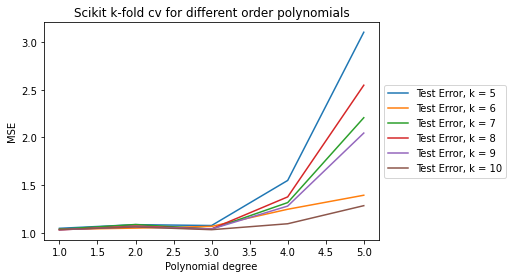

In [14]:
# define the model we want to use 
solver = LR

#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True}

plot_Kfold_scikit(features,labels , k_values, degree_values, fig_name ='c_scikit_kfold_withnoise_', solver = solver , **solver_args) 


#### Without noise

MSE on test-set : 
 [[0.04576671 0.03874027 0.03839682 0.03467602 0.03352505 0.03379264]
 [0.11228997 0.0684227  0.05652764 0.04264218 0.03974759 0.03686937]
 [0.01820134 0.01337367 0.01286016 0.01229501 0.01220757 0.0111079 ]
 [0.09289967 0.04102599 0.02131225 0.01729308 0.01635007 0.01698624]
 [0.13528561 0.03653383 0.02653421 0.00997742 0.00951974 0.01010605]]


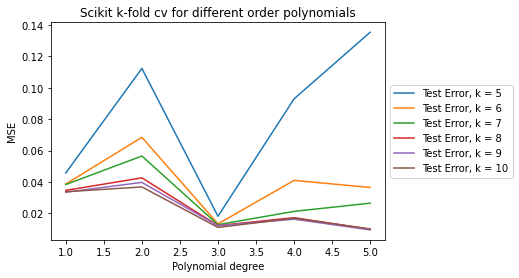

In [15]:

plot_Kfold_scikit(features,labels , k_values, degree_values, scaling= True, add_noise= False, fig_name= 'c_scikit_kfold_without_noise_',solver = solver , **solver_args) 
